<h1 style="color:blue;">Setting up Dependencies</h1>


<h4 >SparkSession - hive<br>

SparkContext<br>

Spark UI<br>

Version<br>
    v2.4.0<br>
Master<br>
    local[*]<br>
AppName<br>
PySparkShell</h4>


In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [2]:
import os

# Set spark environments to work with python3
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

In [3]:
import re
import pandas as pd

<h1 style="color:blue;">Basic Regular Expressions</h1>

In [4]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<_sre.SRE_Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<_sre.SRE_Match object; span=(25, 36), match=' in PySpark'> 25 36


<h1 style="color:blue;">Loading the dataset</h1>

In [5]:
acunetix = "data/acunetix.txt"

<h1 style="color:blue">Taking a look at the metadata of our dataframe</h1>

In [6]:
base_df = spark.read.text(acunetix)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [7]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [8]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

<h1 style="color:blue;">Viewing sample data in our dataframe </h1>
<h4>Looks like it needs to be wrangled and parsed!</h4>

In [9]:
base_df.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|"192.168.4.25 - - [22/Dec/2016:16:30:52 +0300] "POST /administrator/index.php HTTP/1.1"

<h4 style="color:blue;">Getting data from an RDD is slightly different. You can see how the data representation is different in the following RDD<h4>

In [10]:
base_df_rdd.take(10)

[Row(value='"192.168.4.25 - - [22/Dec/2016:16:30:52 +0300] "POST /administrator/index.php HTTP/1.1" 303 382 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:29:05 +0300] "POST /index.php/component/search/ HTTP/1.1" 500 2011 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:28:53 +0300] "POST /index.php/component/search/ HTTP/1.1" 303 374 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:32:50 +0300] "POST /index.php/component/search/ HTTP/1.1" 200 3054 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value

<h1 style="color:blue;">Data Wrangling</h1>
<h4>In this section, we will try and clean and parse our log dataset to really extract structured attributes with meaningful information from each log message.</h4>

<h3 style="color:blue;">Data understanding</h3>

<h4>If you're familiar with web server logs, you'll recognize that the above displayed data is in Common Log Format.</h4>

<h4>The fields are: remotehost rfc931 authuser [date] "request" status bytes</h4>


<h2 style="color:blue;">Data Parsing and Extraction with Regular Expressions</h2>
<h4>Next, we have to parse it into individual columns. We'll use the special built-in regexp_extract() function to do the parsing.<br> This function matches a column against a regular expression with one or more capture groups and allows you to extract one of the matched groups.<br> We'll use one regular expression for each field we wish to extract.<h4>

<h4>You must have heard or used a fair bit of regular expressions by now. <br>If you find regular expressions confusing (and they certainly can be), and you want to learn more about them, we recommend checking out the RegexOne web site. <br>You might also find Regular Expressions Cookbook, by Goyvaerts and Levithan, to be useful as a reference.</h4>

In [11]:
print((base_df.count(), len(base_df.columns)))

(6539, 1)


<h3 style="color:blue;">Let's extract and take a look at some sample log messages</h3>

In [12]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['"192.168.4.25 - - [22/Dec/2016:16:30:52 +0300] "POST /administrator/index.php HTTP/1.1" 303 382 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""',
 '"192.168.4.25 - - [22/Dec/2016:16:29:05 +0300] "POST /index.php/component/search/ HTTP/1.1" 500 2011 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""',
 '"192.168.4.25 - - [22/Dec/2016:16:28:53 +0300] "POST /index.php/component/search/ HTTP/1.1" 303 374 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""',
 '"192.168.4.25 - - [22/Dec/2016:16:32:50 +0300] "POST /index.php/component/search/ HTTP/1.1" 200 3054 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""',
 '"192.168.4.25 - - [22/Dec/2016:16:29:13 +0300] "POST


<h2 style="color:blue;">Extracting host names</h2>
<h4>Let's try and write some regular expressions to extract the host name from the logs</h4>


In [13]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25',
 '"192.168.4.25']


<h2 style="color:blue;">Extracting timestamps</h2>
<h4>Let's now try and use regular expressions to extract the timestamp fields from the logs</h4>

In [14]:
from pyspark.sql.functions import date_format

In [15]:
# \[(?P<time>.+)\]
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} .+\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['22/Dec/2016:16:30:52 +0300',
 '22/Dec/2016:16:29:05 +0300',
 '22/Dec/2016:16:28:53 +0300',
 '22/Dec/2016:16:32:50 +0300',
 '22/Dec/2016:16:29:13 +0300',
 '22/Dec/2016:16:29:33 +0300',
 '22/Dec/2016:16:24:39 +0300',
 '22/Dec/2016:16:28:52 +0300',
 '22/Dec/2016:16:28:58 +0300',
 '22/Dec/2016:16:21:56 +0300',
 '22/Dec/2016:16:20:49 +0300',
 '22/Dec/2016:16:18:20 +0300',
 '22/Dec/2016:16:28:11 +0300',
 '22/Dec/2016:16:25:15 +0300',
 '22/Dec/2016:16:26:04 +0300']


<h2 style="color:blue;">Extracting HTTP Request Method, URIs and Protocol</h2>

<h4>Let's now try and use regular expressions to extract the HTTP request methods, URIs and Protocol patterns fields from the logs</h4>

In [16]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('POST', '/administrator/index.php', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('GET',
  '/index.php/component/search/?searchword=&ordering=alpha&searchphrase=all&areas[0]=newsfeeds',
  'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('GET', '/templates/beez_20/css/personal.css', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1'),
 ('POST', '/index.php/component/search/', 'HTTP/1.1')]


<h2 style="color:blue;">Extracting HTTP Status Codes</h2>
<h4>Let's now try and use regular expressions to extract the HTTP status codes from the logs</h4>


In [17]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['303', '500', '303', '200', '200', '200', '303', '303', '200', '303', '303', '200', '303', '303', '303']


<h2 style="color:blue;">Extracting HTTP Response Content Size</h2>

<h4>Let's now try and use regular expressions to extract the HTTP response content size from the logs</h4>

In [18]:
content_size_pattern = r'\s(\d+) \"'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['382', '2011', '374', '3054', '3056', '3122', '412', '377', '3052', '376', '376', '4918', '378', '372', '371']



<h2 style="color:blue;">Putting it all together</h2>
<h4>Let's now try and leverage all the regular expression patterns we previously built and use the regexp_extract(...) method to build our dataframe with all the log attributes neatly extracted in their own separate columns.</h4>

In [19]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+-------------+--------------------+------+--------------------+--------+------+------------+
|         host|           timestamp|method|            endpoint|protocol|status|content_size|
+-------------+--------------------+------+--------------------+--------+------+------------+
|"192.168.4.25|22/Dec/2016:16:30...|  POST|/administrator/in...|HTTP/1.1|   303|         382|
|"192.168.4.25|22/Dec/2016:16:29...|  POST|/index.php/compon...|HTTP/1.1|   500|        2011|
|"192.168.4.25|22/Dec/2016:16:28...|  POST|/index.php/compon...|HTTP/1.1|   303|         374|
|"192.168.4.25|22/Dec/2016:16:32...|  POST|/index.php/compon...|HTTP/1.1|   200|        3054|
|"192.168.4.25|22/Dec/2016:16:29...|  POST|/index.php/compon...|HTTP/1.1|   200|        3056|
|"192.168.4.25|22/Dec/2016:16:29...|   GET|/index.php/compon...|HTTP/1.1|   200|        3122|
|"192.168.4.25|22/Dec/2016:16:24...|  POST|/index.php/compon...|HTTP/1.1|   303|         412|
|"192.168.4.25|22/Dec/2016:16:28...|  POST|/index.php/compon


<h2 style="color:blue;">Finding Missing Values</h2>
<h4>Missing and null values are the bane of data analysis and machine learning. Let's see how well our data parsing and extraction logic worked. First, let's verify that there are no null rows in the original dataframe.</h4>

In [20]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())


0

<h2 style="color:blue;">If our data parsing and extraction worked properly, we should not have any rows with potential null values. Let's try and put that to test!</h2>

In [21]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

0

<h2 style="color:blue;">Finding Null Counts</h2>

In [22]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [23]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling nulls in HTTP status</h2>
<h4>Our original parsing regular expression for the status column was:<br>

regexp_extract('value', r'\s(\d{3})\s', 1).cast('integer').alias('status')</br>

Could it be that there are more digits making our regular expression wrong? or is the data point itself bad? Let's try and find out!</br>

Note: In the expression below, ~ means "not".</h4>


In [24]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

0

In [25]:
null_status_df.show(truncate=False)

+-----+
|value|
+-----+
+-----+



In [26]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
+----+---------+------+--------+--------+------+------------+



In [27]:
logs_df.count()

6539

In [28]:
logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

6539

In [29]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling nulls in HTTP content size</h2>
<h4>Based on our previous regular expression, our original parsing regular expression for the content_size column was:<br>
regexp_extract('value', r'\s(\d+)$', 1).cast('integer').alias('content_size')</h4>
<h3>Find out the records in our base data frame with potential missing content sizes</h3>

In [30]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

6539

In [31]:
null_content_size_df.take(10)

[Row(value='"192.168.4.25 - - [22/Dec/2016:16:30:52 +0300] "POST /administrator/index.php HTTP/1.1" 303 382 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:29:05 +0300] "POST /index.php/component/search/ HTTP/1.1" 500 2011 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:28:53 +0300] "POST /index.php/component/search/ HTTP/1.1" 303 374 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value='"192.168.4.25 - - [22/Dec/2016:16:32:50 +0300] "POST /index.php/component/search/ HTTP/1.1" 200 3054 "http://192.168.4.161/DVWA" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.21 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.21""'),
 Row(value

In [32]:
logs_df = logs_df.na.fill({'content_size': 0})

In [33]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling Temporal Fields (Timestamp)</h2>
<h4>Now that we have a clean, parsed DataFrame, we have to parse the timestamp field into an actual timestamp.<br> The Common Log Format time is somewhat non-standard.<br> A User-Defined Function (UDF) is the most straightforward way to parse it.</h4>


In [34]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [35]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['22/Dec/2016:16:30:52 +0300',
 '22/Dec/2016:16:29:05 +0300',
 '22/Dec/2016:16:28:53 +0300',
 '22/Dec/2016:16:32:50 +0300',
 '22/Dec/2016:16:29:13 +0300']

In [36]:
# [parse_clf_time(item) for item in sample_ts]

In [37]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+-------------+------+--------------------+--------+------+------------+-------------------+
|         host|method|            endpoint|protocol|status|content_size|               time|
+-------------+------+--------------------+--------+------+------------+-------------------+
|"192.168.4.25|  POST|/administrator/in...|HTTP/1.1|   303|         382|2016-12-22 16:30:52|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   500|        2011|2016-12-22 16:29:05|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   303|         374|2016-12-22 16:28:53|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   200|        3054|2016-12-22 16:32:50|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   200|        3056|2016-12-22 16:29:13|
|"192.168.4.25|   GET|/index.php/compon...|HTTP/1.1|   200|        3122|2016-12-22 16:29:33|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   303|         412|2016-12-22 16:24:39|
|"192.168.4.25|  POST|/index.php/compon...|HTTP/1.1|   303|         37

In [38]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [39]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,"""192.168.4.25",POST,/administrator/index.php,HTTP/1.1,303,382,2016-12-22 16:30:52
1,"""192.168.4.25",POST,/index.php/component/search/,HTTP/1.1,500,2011,2016-12-22 16:29:05
2,"""192.168.4.25",POST,/index.php/component/search/,HTTP/1.1,303,374,2016-12-22 16:28:53
3,"""192.168.4.25",POST,/index.php/component/search/,HTTP/1.1,200,3054,2016-12-22 16:32:50
4,"""192.168.4.25",POST,/index.php/component/search/,HTTP/1.1,200,3056,2016-12-22 16:29:13


In [40]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

<h2 style="color:blue;">Data Analysis on our Web Logs</h2>
<h4>Now that we have a DataFrame containing the parsed log file as a data frame, we can perform some interesting exploratory data analysis (EDA)</h4>
<h3>Content Size Statistics</h3>

<h4>Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.</h4>

<h4>We can compute the statistics by calling .describe() on the content_size column of logs_df. The .describe() function returns the count, mean, stddev, min, and max of a given column.</h4>

In [41]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,6539
1,mean,1274.8664933476066
2,stddev,1882.2479225751963
3,min,223
4,max,68451


In [42]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,223,68451,1274.866493,1882.247923,6539



<h2 style="color:blue;">HTTP Status Code Analysis</h2>
<h4>Next, let's look at the status code values that appear in the log. We want to know which status code values appear in the data and how many times.</h4>

<h4>We again start with logs_df, then group by the status column, apply the .count() aggregation function, and sort by the status column</h4>


In [43]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [44]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 8


In [45]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
3,303,3407
0,200,2036
7,500,706
6,404,258
2,302,99
1,301,18
4,400,12
5,403,3


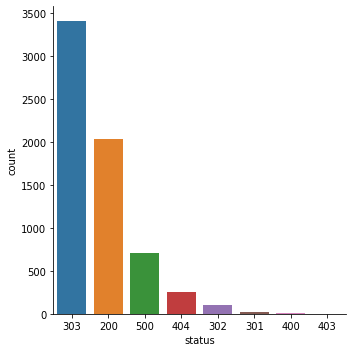

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [47]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-----+------------------+
|status|count|        log(count)|
+------+-----+------------------+
|   200| 2036| 7.618742377670413|
|   301|   18|2.8903717578961645|
|   302|   99|  4.59511985013459|
|   303| 3407| 8.133587417660966|
|   400|   12|2.4849066497880004|
|   403|    3|1.0986122886681096|
|   404|  258| 5.552959584921617|
|   500|  706| 6.559615237493242|
+------+-----+------------------+



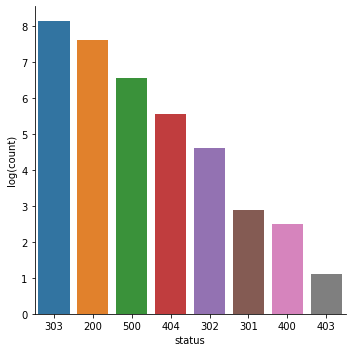

In [48]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])


<h2 style="color:blue;">HTTP methods Analysis</h2>

In [54]:
method_freq_df = (logs_df
                     .groupBy('method')
                     .count()
                     .sort('method')
                     .cache())

In [55]:
print('Total distinct HTTP Status Codes:', method_freq_df.count())

Total distinct HTTP Status Codes: 3


In [56]:
method_freq_pd_df = (method_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
method_freq_pd_df

,method,count
2,POST,5499
1,GET,1039
0,"-""",1


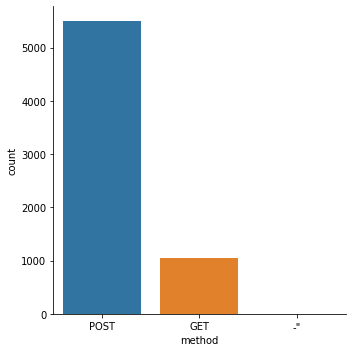

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='method', y='count', data=method_freq_pd_df, 
            kind='bar', order=method_freq_pd_df['method'])

In [61]:
mlog_freq_df = method_freq_df.withColumn('log(count)', F.log(method_freq_df['count']))
mlog_freq_df.show()

+------+-----+-----------------+
|method|count|       log(count)|
+------+-----+-----------------+
|    -"|    1|              0.0|
|   GET| 1039|6.946013991099227|
|  POST| 5499|8.612321536507814|
+------+-----+-----------------+



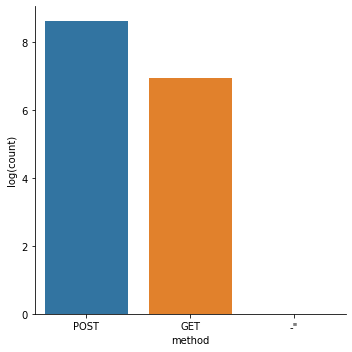

In [63]:
mlog_freq_pd_df = (mlog_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='method', y='log(count)', data=mlog_freq_pd_df, 
            kind='bar', order=method_freq_pd_df['method'])


<h2 style="color:blue;">Analyzing Frequent Hosts</h2>

<h4>Let's look at hosts that have accessed the server frequently. We will try to get the count of total accesses by each host and then sort by the counts and display only the top ten most frequent hosts.</h4>

In [49]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False))

host_sum_df.show(truncate=False)

+-------------+-----+
|host         |count|
+-------------+-----+
|"192.168.4.25|6539 |
+-------------+-----+



In [50]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[0]['host']

'"192.168.4.25'


<h2 style="color:blue;">Display the  Frequent EndPoints</h2>


In [54]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False))

In [55]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/index.php/component/search/,4167
1,/index.php,579
2,/administrator/index.php,307
3,/index.php/component/users/?task=user.login,184
4,/index.php/component/users/?task=registration....,114
...,...,...
933,"/'\""/component/search/",1
934,/index.php/component/users/?task=qTo3ig5t'));s...,1
935,/index.php/component/search/?ordering=category...,1
936,/index.php/component/content/?format=feed&type...,1



<h2 style="color:blue;"> Error Endpoints</h2>


In [58]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                          )

In [59]:
error_endpoints_freq_df.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------+-----+
|endpoint                                                                                                        |count|
+----------------------------------------------------------------------------------------------------------------+-----+
|/index.php/component/search/                                                                                    |3330 |
|/administrator/index.php                                                                                        |290  |
|/index.php                                                                                                      |278  |
|/index.php/component/users/?task=user.login                                                                     |94   |
|/DVWA/login.php                                                                                                 |40   |
|/index.php/component/users/?tas


<h2 style="color:blue;"> Total number of Unique Hosts</h2>




In [60]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

1

<h2 style="color:blue;">Number of Unique Daily Hosts</h2>


In [63]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+-------------+---+
|host         |day|
+-------------+---+
|"192.168.4.25|22 |
|"192.168.4.25|22 |
|"192.168.4.25|22 |
|"192.168.4.25|22 |
|"192.168.4.25|22 |
+-------------+---+
only showing top 5 rows



In [64]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-------------+---+
|host         |day|
+-------------+---+
|"192.168.4.25|22 |
+-------------+---+



In [65]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,22,1


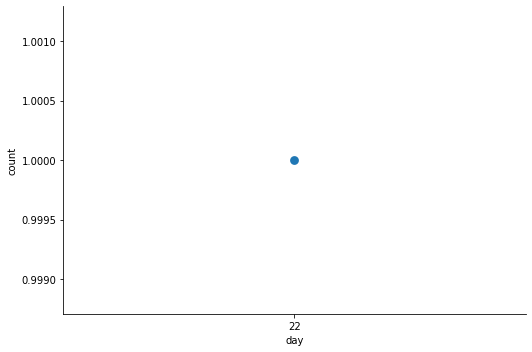

In [66]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)


<h2 style="color:blue;">Average Number of Daily Requests per Host</h4>


In [67]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,22,6539,1,6539.0


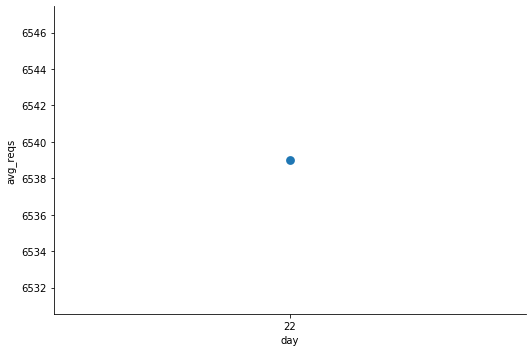

In [68]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)


<h2 style="color:blue;">Counting 404 Response Codes</h2>



In [69]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 258


<h2 style="color:blue;">Listing the Top Twenty 404 Response Code Endpoints</h2>

In [70]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|endpoint                                                                                                                                                                                                             |count|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|/index.php                                                                                                                                                                                                           |47   |
|/index.php/component/users/?task=registration.register                                                         

<h2 style="color:blue;">Listing the Top Twenty 404 Response Code Hosts</h2>

In [71]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+-------------+-----+
|host         |count|
+-------------+-----+
|"192.168.4.25|258  |
+-------------+-----+



<h2 style="color:blue;">Visualizing 404 Errors per Day</h2>

In [72]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,22,258


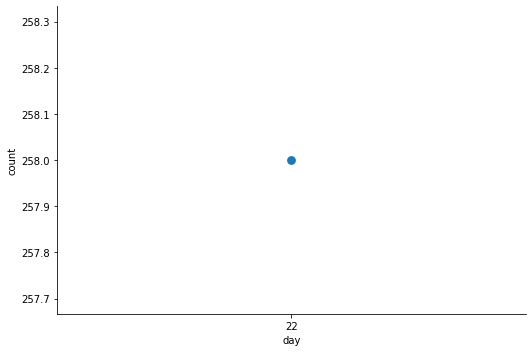

In [73]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

<h2 style="color:blue;">Top Three Days for 404 Errors</h2>

In [74]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
| 22|  258|
+---+-----+



<h2 style="color:blue;">Visualizing Hourly 404 Errors</h2>

In [68]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

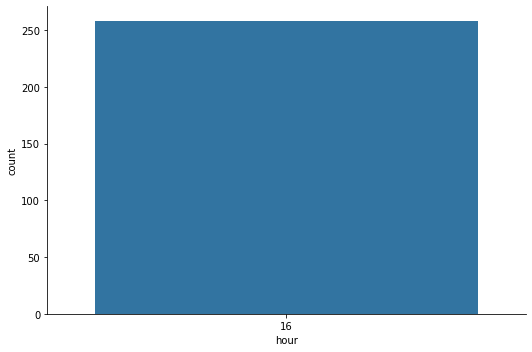

In [69]:
c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)